In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# keras import
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
# from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import concatenate, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.utils import to_categorical
from keras.models import load_model
from datetime import time


from keras.layers import Dense, Flatten
from keras.layers import LSTM, Dropout, Input, Conv1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import he_normal
# fix random seed for reproducibility
from keras.models import load_model
from sklearn.model_selection import train_test_split
np.random.seed(7)
from keras.preprocessing.text import Tokenizer
from scipy.sparse import hstack

import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import corpora
import pickle

from tqdm import tqdm
import os

Using TensorFlow backend.


In [2]:
d = pd.read_csv('preprocessed_data.csv')
d.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(d, test_size=0.3)

In [4]:
train_df.shape, test_df.shape

((76473, 9), (32775, 9))

## Test data vectorizatio

### Training word2vec model on train data

In [5]:
x_train_essay_text = train_df.essay.values.tolist()
x_test_essay_text = test_df.essay.values.tolist()

In [6]:
# tokenizing 
# https://stackoverflow.com/questions/52126539/using-pretrained-gensim-word2vec-embedding-in-keras
# https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
t = Tokenizer()
t.fit_on_texts(x_train_essay_text)
vocab_size = len(t.word_index) + 1
print(len(t.word_index))

49086


In [7]:
# load embedding as a dict
def load_embedding(filename):

    # load embedding into memory, skip first line
    file = open(filename, 'r')
    lines = file.readlines()[1:]
    
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

# load embedding from file
raw_embedding = load_embedding('glove.6B.300d.txt')
# raw_embedding = load_embedding('glove.42B.300d.txt')

# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, t.word_index)
where_are_NaNs = np.isnan(embedding_vectors)
embedding_vectors[where_are_NaNs] = 0

In [115]:
# np.any(np.isnan(embedding_vectors))
# np.all(np.isfinite(embedding_vectors))

False

In [99]:
# Train your own Word2Vec model using your own text corpus
# def sentenceSplit(data):
#     list_of_sentance=[]
#     for sentance in data:
#         list_of_sentance.append(sentance.split())
#     return list_of_sentance

# # this line of code trains your w2v model on the give list of sentances
# list_of_sentance_train = sentenceSplit(x_train_essay_text)
# w2v_model=Word2Vec(list_of_sentance_train, size=150, workers=4)
# w2v_words = list(w2v_model.wv.vocab)

# w2v_model.save("dc_lstm_w2vmodel")
# Load pre-trained Word2Vec model.

# w2v_model = Word2Vec.load("dc_lstm_w2vmodel") 

#### 1 Train and Test data for text feature

In [7]:
# Train data
# enocde it to sequences
encoded_docs = t.texts_to_sequences(x_train_essay_text)

# padding
max_length = len(max(x_train_essay_text, key=len).split(' '))

x_train_text = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_train_text.shape

(76473, 328)

In [8]:
# Test
# enocde it to sequences
encoded_docs = t.texts_to_sequences(x_test_essay_text)
x_test_text = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_test_text.shape

(32775, 328)

In [100]:
# # create a weight matrix for the Embedding layer from a loaded embedding
# def get_weight_matrix(embedding, vocab):
#     # total vocabulary size plus 0 for unknown words
#     vocab_size = len(vocab) + 1
#     # define weight matrix dimensions with all 0
#     weight_matrix = np.zeros((vocab_size, w2v_model.vector_size))
    
#     # step vocab, store vectors using the Tokenizer's integer mapping
#     for word, i in vocab.items():
#         if word not in w2v_model.wv.vocab:
#             continue
            
#         weight_matrix[i] = embedding.wv[word]# embedding.get(word)
        
#     return weight_matrix

# # load embedding from file
# # raw_embedding = load_embedding('glove.42B.300d.txt')

# # get vectors in the right order
# # embedding_vectors = get_weight_matrix(raw_embedding, t.word_index)
# embedding_vectors = get_weight_matrix(w2v_model, t.word_index)

In [15]:
# embedding_vectors[49080]

In [16]:
# model = Sequential()
# e = Embedding(vocab_size, 128, weights=[embedding_vectors], input_length=x_train_text.shape[1], trainable=False)
# model.add(e)
# model.add(Flatten())

# # summarize the model
# print(model.summary())


## Categorical Featurization

#### 2 school state

In [21]:
len(set(train_df.school_state.values.tolist()))

51

In [22]:
train_sch_state = train_df.school_state.values.tolist()
test_sch_state = test_df.school_state.values.tolist()
# no_words = len(set(train_sch_state))

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sch_state)
train_sch_state = tokenizer.texts_to_sequences(train_sch_state)
test_sch_state = tokenizer.texts_to_sequences(test_sch_state)

In [24]:
# Train data
max_length = len(max(train_sch_state, key=len))
x_train_sch_state = sequence.pad_sequences(train_sch_state, maxlen = max_length, padding='post')
x_train_sch_state.shape

(76473, 1)

In [25]:
# Test data
x_test_sch_state = sequence.pad_sequences(test_sch_state, maxlen = max_length, padding='post')
x_test_sch_state.shape

(32775, 1)

#### 3 Project grade

In [26]:
len(set(train_df.project_grade_category.values.tolist()))

4

In [27]:
train_df['project_grade_category'] = train_df['project_grade_category'].str.replace('_','')
test_df['project_grade_category'] = test_df['project_grade_category'].str.replace('_','')
# max_length = 1 #len(max(train_proj_grade))

In [28]:
train_proj_grade = train_df.project_grade_category.values.tolist()
test_proj_grade = test_df.project_grade_category.values.tolist()
max_length = 1 #len(max(train_proj_grade))

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_proj_grade)
train_proj_grade = tokenizer.texts_to_sequences(train_proj_grade)
test_proj_grade = tokenizer.texts_to_sequences(test_proj_grade)

In [30]:
tokenizer.word_index

{'gradesprek2': 1, 'grades35': 2, 'grades68': 3, 'grades912': 4}

In [31]:
# Train data
x_train_proj_grade = sequence.pad_sequences(train_proj_grade, maxlen = max_length, padding='post')
x_train_proj_grade.shape

(76473, 1)

In [32]:
# Train data
x_test_proj_grade = sequence.pad_sequences(test_proj_grade, maxlen = max_length, padding='post')
x_test_proj_grade.shape

(32775, 1)

#### 4 clean_cat

In [33]:
len(set(train_df.clean_categories.values.tolist()))

51

In [34]:
train_clean_cat = train_df.clean_categories.values.tolist()
test_clean_cat = test_df.clean_categories.values.tolist()
# max_length = len(max(train_clean_cat, key=len).split(' '))
max_length = 1

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean_cat)
train_clean_cat = tokenizer.texts_to_sequences(train_clean_cat)
test_clean_cat = tokenizer.texts_to_sequences(test_clean_cat)

In [36]:
# Train data
x_train_clean_cat = sequence.pad_sequences(train_clean_cat, maxlen = max_length, padding='post')
x_train_clean_cat.shape

(76473, 1)

In [37]:
# Test data
x_test_clean_cat = sequence.pad_sequences(test_clean_cat, maxlen = max_length, padding='post')
x_test_clean_cat.shape

(32775, 1)

#### 5 clean_sub_cat

In [38]:
len(set(train_df.clean_subcategories.values.tolist()))

395

In [39]:
# train_df.clean_subcategories.values.tolist()

In [40]:
train_clean_sub_cat = train_df.clean_subcategories.values.tolist()
test_clean_sub_cat = test_df.clean_subcategories.values.tolist()
max_length = 1#len(max(train_clean_sub_cat, key=len).split(' '))

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean_sub_cat)
train_clean_sub_cat = tokenizer.texts_to_sequences(train_clean_sub_cat)
test_clean_sub_cat = tokenizer.texts_to_sequences(test_clean_sub_cat)

In [42]:
# Train data
x_train_clean_sub_cat = sequence.pad_sequences(train_clean_sub_cat, maxlen = max_length, padding='post')
x_train_clean_sub_cat.shape

(76473, 1)

In [43]:
# Test data
x_test_clean_sub_cat = sequence.pad_sequences(test_clean_sub_cat, maxlen = max_length, padding='post')
x_test_clean_sub_cat.shape

(32775, 1)

#### 6 Teacher_prefix

In [44]:
len(set(train_df.teacher_prefix.values.tolist()))

5

In [45]:
train_teacher_prefix = train_df.teacher_prefix.values.tolist()
test_teacher_prefix = test_df.teacher_prefix.values.tolist()
max_length = 1

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_teacher_prefix)
train_teacher_prefix = tokenizer.texts_to_sequences(train_teacher_prefix)
test_teacher_prefix = tokenizer.texts_to_sequences(test_teacher_prefix)

In [47]:
# Train data
x_train_teacher_prefix = sequence.pad_sequences(train_teacher_prefix, maxlen = max_length, padding='post')
x_train_teacher_prefix.shape

(76473, 1)

In [48]:
# Train data
x_test_teacher_prefix = sequence.pad_sequences(test_teacher_prefix, maxlen = max_length, padding='post')
x_test_teacher_prefix.shape

(32775, 1)

## Numerical Featurization

#### number of previously posted project

In [49]:
x_train_previously_posted_projects = train_df['teacher_number_of_previously_posted_projects']#train_df.teacher_number_of_previously_posted_projects.values
#x_train_previously_posted_projects = x_train_previously_posted_projects.reshape(76473, 1)
#x_train_previously_posted_projects.shape

In [50]:
x_test_previously_posted_projects = test_df['teacher_number_of_previously_posted_projects']#test_df.teacher_number_of_previously_posted_projects.values
#x_test_previously_posted_projects = x_test_previously_posted_projects.reshape(32775, 1)
#x_test_previously_posted_projects.shape

In [36]:
# x_train_previously_posted_projects.shape

# Deep Learning Model 1
#### Model-1 Architecture

[FullSizeImage](https://i.imgur.com/w395Yk9.png)
<img src='https://i.imgur.com/w395Yk9.png'>

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



In [37]:
# 1.x = Dropout(0.5)(x) output = Dense(2, activation = 'softmax')(x)

# Can you try removing this dropout and see if the performance could be imporved?

# 2. For model 2 , take idf range from 2 to 10 for keeping the words. This would increase the auc score. 

# 3. Make sure the test AUC for all the three models is more than 0.70. 

In [38]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auroc(y_true, y_pred):
    # print(y_true, y_pred)
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [40]:
#input 1
input_1 = Input(shape=(328,))
x1 =Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=x_train_text.shape[1], trainable=False)(input_1)
x1 = Dropout(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52, output_dim= 2)(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,))
x3 = Embedding(input_dim = 5, output_dim= 2)(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,))
x4 = Embedding(input_dim=52,output_dim= 2)(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,))
x5 = Embedding(input_dim= 396, output_dim= 64)(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 4)(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128, activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# model with all the inputs
model = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
print(model.summary())

In [ ]:
y_train = train_df.project_is_approved.values.tolist()
y_test = test_df.project_is_approved.values.tolist()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [41]:
x_train =  [x_train_text, x_train_sch_state, x_train_proj_grade, x_train_clean_cat, x_train_clean_sub_cat, x_train_teacher_prefix, x_train_previously_posted_projects]
x_test = [x_test_text, x_test_sch_state, x_test_proj_grade, x_test_clean_cat, x_test_clean_sub_cat, x_test_teacher_prefix, x_test_previously_posted_projects]

In [5]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.fit(x_train, y_train, nb_epoch=20,verbose=1,batch_size=128, callbacks =callbacks_list)
# model.save('dc_model1.h5')

In [42]:
# https://github.com/keras-team/keras/issues/10104
dependencies = {
    'auroc': auroc
}
model = load_model("dc_model2.h5", custom_objects=dependencies)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    



In [43]:
### Testing model-1
y_train_pred = model.predict(x_train)
print("Train AUC:",roc_auc_score(y_train,y_train_pred))

Train AUC: 0.9791035547455924


In [44]:
y_test_pred = model.predict(x_test)
print("Test AUC:",roc_auc_score(y_test,y_test_pred))

Test AUC: 0.7008411718577311


# Deep Learning Model 2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

- Train the TF-IDF on the Train data.
- Get the idf value for each word we have in the train data.
- Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)
- Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)

In [5]:
# Save to file in the current working directory
def saveModel(filename, model):
    try:
        import cPickle as pickle

    except ImportError:
        import pickle

    with open(filename, 'wb') as fp:
        pickle.dump(model, fp, protocol=pickle.HIGHEST_PROTOCOL)

    return

In [6]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:
        pickle_model = pickle.load(file)
    return pickle_model

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
x_train_essay_text = train_df.essay.values.tolist()
x_test_essay_text = test_df.essay.values.tolist()

In [39]:
vectorizer = TfidfVectorizer(min_df=10, max_features=10000)
vectorizer.fit(x_train_essay_text) 
x_train_tfidf  = vectorizer.transform(x_train_essay_text)

Text(0, 0.5, 'IDF Value')

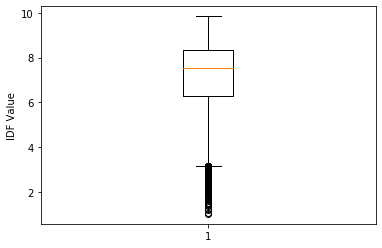

In [40]:
# box plot to decide the threshold
plt.boxplot(vectorizer.idf_)
plt.ylabel("IDF Value")

In [41]:
# sortedDiff =np.sort(diff)
for i in range (0,101,10):
    p = np.percentile(vectorizer.idf_, i)
    print(str(i)+" Percentile: "+ str(p))

0 Percentile: 1.0077317773707817
10 Percentile: 4.961189206264439
20 Percentile: 5.876176147118889
30 Percentile: 6.59925919512169
40 Percentile: 7.108907655714666
50 Percentile: 7.5442257269725115
60 Percentile: 7.887997266075336
70 Percentile: 8.201654824930378
80 Percentile: 8.50703647448156
90 Percentile: 8.7789701899652
100 Percentile: 9.846810819966556


<p>After 70th percentile idf value nearly remain same. </p>
    -min_threshold = 20th percentile<br>
    -max_threshold = 80th percentile<br>

In [42]:
min_threshold = 3 # np.percentile(vectorizer.idf_, 20)
max_threshold = np.percentile(vectorizer.idf_, 90)
print(min_threshold, max_threshold)

3 8.7789701899652


In [43]:
feat = vectorizer.get_feature_names()
idf_val = vectorizer.idf_
len(feat), len(idf_val)
feat_idf_dict = dict(zip(feat, idf_val))

In [44]:
# new_data = {k: v for k, v in feat_idf_dict.iteritems() if min_threshold < v[0] < max_threshold}
for k  in list(feat_idf_dict.keys()):
    # removing low and high idf features
    if (min_threshold >= feat_idf_dict[k]) or (feat_idf_dict[k] >= max_threshold):
        feat_idf_dict.pop(k)

len(feat_idf_dict)

8831

In [9]:
# removing low and high idf words from dataset
def get_filtered_text(text_dataset):
    
    filtered_text = []
    for text in tqdm(text_dataset):
        resultwords  = [word for word in text.split() if word.lower() in list(feat_idf_dict.keys())]
        result = ' '.join(resultwords)
        filtered_text.append(result)
    
    return filtered_text

In [10]:
# x_train_essay_text_filtered = get_filtered_text(x_train_essay_text)
# saveModel("x_train_tfidf_filter_3.pkl", x_train_essay_text_filtered)

# x_test_essay_text_filtered = get_filtered_text(x_test_essay_text)
# saveModel("x_test_tfidf_filter_3.pkl", x_test_essay_text_filtered)

x_train_essay_text_filtered = getModel("x_train_tfidf_filter_3.pkl")
x_test_essay_text_filtered = getModel("x_test_tfidf_filter_3.pkl")

In [11]:
# tokenizing 
t = Tokenizer()
t.fit_on_texts(x_train_essay_text_filtered)
vocab_size = len(t.word_index) + 1
print(len(t.word_index))

8831


In [13]:
# load embedding as a dict
def load_embedding(filename):

    # load embedding into memory, skip first line
    file = open(filename, 'r')
    lines = file.readlines()[1:]
    
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 200))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

# load embedding from file
raw_embedding = load_embedding('glove.6B/glove.6B.200d.txt')
# raw_embedding = load_embedding('glove.42B.300d.txt')

# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, t.word_index)
where_are_NaNs = np.isnan(embedding_vectors)
embedding_vectors[where_are_NaNs] = 0

In [14]:
# Train
# enocde it to sequences
encoded_docs = t.texts_to_sequences(x_train_essay_text_filtered)
max_length = len(max(x_train_essay_text_filtered, key=len).split(' '))
x_train_text_M2 = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_train_text_M2.shape

# Test
encoded_docs = t.texts_to_sequences(x_test_essay_text_filtered)
x_test_text_M2 = sequence.pad_sequences(encoded_docs, maxlen = max_length, padding='post')
x_test_text_M2.shape

(32775, 216)

In [15]:
x_train_text_M2.shape

(76473, 216)

In [16]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auroc(y_true, y_pred):
    # print(y_true, y_pred)
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [18]:
#input 1
input_1 = Input(shape=(216,))
x1 =Embedding(vocab_size, 200, weights=[embedding_vectors], input_length=x_train_text_M2.shape[1], trainable=False)(input_1)
x1 = Dropout(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52, output_dim= 2)(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,))
x3 = Embedding(input_dim = 5, output_dim= 2)(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,))
x4 = Embedding(input_dim=52,output_dim= 2)(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,))
x5 = Embedding(input_dim= 396, output_dim= 64)(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 4)(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128, activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# model with all the inputs
model = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
print(model.summary())

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216)          0                                            
_____________

In [19]:
from keras.utils import to_categorical
y_train = train_df.project_is_approved.values.tolist()
y_test = test_df.project_is_approved.values.tolist()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [51]:
x_train =  [x_train_text_M2, x_train_sch_state, x_train_proj_grade, x_train_clean_cat, x_train_clean_sub_cat, x_train_teacher_prefix, x_train_previously_posted_projects]
x_test = [x_test_text_M2, x_test_sch_state, x_test_proj_grade, x_test_clean_cat, x_test_clean_sub_cat, x_test_teacher_prefix, x_test_previously_posted_projects]

In [52]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath = "weight_model2_v3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.fit(x_train, y_train, nb_epoch=20,verbose=1,batch_size=128, callbacks =callbacks_list)
model.save('dc_model2_v4.h5')




Epoch 1/20
76473/76473 [==============================] - 232s 3ms/step - loss: 0.6362 - auroc: 0.5400

Epoch 2/20
76473/76473 [==============================] - 245s 3ms/step - loss: 0.4998 - auroc: 0.5909
Epoch 3/20
76473/76473 [==============================] - 255s 3ms/step - loss: 0.4864 - auroc: 0.5318
Epoch 4/20
76473/76473 [==============================] - 297s 4ms/step - loss: 0.4682 - auroc: 0.5128
Epoch 5/20
76473/76473 [==============================] - 346s 5ms/step - loss: 0.4554 - auroc: 0.5356
Epoch 6/20
76473/76473 [==============================] - 303s 4ms/step - loss: 0.4431 - auroc: 0.5962
Epoch 7/20
76473/76473 [==============================] - 312s 4ms/step - loss: 0.4369 - auroc: 0.5950
Epoch 8/20
76473/76473 [==============================] - 307s 4ms/step - loss: 0.4259 - auroc: 0.6503
Epoch 9/20
76473/76473 [==============================] - 285s 4ms/step - loss: 0.4156 - auroc: 0.6784
Epoch 10/20
76473/76473 [==============================] - 262s 3ms/s

In [53]:
# https://github.com/keras-team/keras/issues/10104
dependencies = {
    'auroc': auroc
}

model = load_model("dc_model2_v3.h5", custom_objects=dependencies)

In [55]:
### Testing model-2
y_train_pred = model.predict(x_train)
print("Train AUC:",roc_auc_score(y_train,y_train_pred))

Train AUC: 0.7860399617088681


In [54]:
y_test_pred = model.predict(x_test)
print("Test AUC:",roc_auc_score(y_test,y_test_pred))

Test AUC: 0.7298947683956255


# Model 3

[FullSizeImage](https://i.imgur.com/fkQ8nGo.png)
<img src='https://i.imgur.com/fkQ8nGo.png'>


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [98]:
# http://flovv.github.io/Embeddings_with_keras_part2/
# school state
token = CountVectorizer()
# integer encode the documents
x_train_sch_state = token.fit_transform(train_df.school_state)
x_test_sch_state = token.transform(test_df.school_state)
print(x_train_sch_state.shape, x_test_sch_state.shape)

(76473, 51) (32775, 51)


- x_train_sch_state, x_train_proj_grade, x_train_clean_cat, x_train_clean_sub_cat, x_train_teacher_prefix, x_train_previously_posted_projects

In [99]:
# proj_grade
token = CountVectorizer()
# integer encode the documents
x_train_proj_grade = token.fit_transform(train_df.project_grade_category)
x_test_proj_grade = token.transform(test_df.project_grade_category)
print(x_train_proj_grade.shape, x_test_proj_grade.shape)

(76473, 4) (32775, 4)


In [100]:
# clean_cat
token = CountVectorizer()
# integer encode the documents
x_train_clean_cat = token.fit_transform(train_df.clean_categories)
x_test_clean_cat = token.transform(test_df.clean_categories)
print(x_train_clean_cat.shape, x_test_clean_cat.shape)

(76473, 9) (32775, 9)


In [101]:
# x_train_clean_sub_cat
token = CountVectorizer()
# integer encode the documents
x_train_clean_sub_cat = token.fit_transform(train_df.clean_subcategories)
x_test_clean_sub_cat = token.transform(test_df.clean_subcategories)
print(x_train_clean_sub_cat.shape, x_test_clean_sub_cat.shape)

(76473, 30) (32775, 30)


In [102]:
# x_train_teacher_prefix
token = CountVectorizer()
# integer encode the documents
x_train_teacher_prefix = token.fit_transform(train_df.teacher_prefix)
x_test_teacher_prefix = token.transform(test_df.teacher_prefix)
print(x_train_teacher_prefix.shape, x_test_teacher_prefix.shape)

(76473, 5) (32775, 5)


In [103]:
x_train_previously_posted_projects = train_df.teacher_number_of_previously_posted_projects.values
x_train_previously_posted_projects = x_train_previously_posted_projects.reshape(76473, 1)
#x_train_previously_posted_projects.shape
x_test_previously_posted_projects = test_df.teacher_number_of_previously_posted_projects.values
x_test_previously_posted_projects = x_test_previously_posted_projects.reshape(32775, 1)
print(x_train_previously_posted_projects.shape, x_test_previously_posted_projects.shape)

(76473, 1) (32775, 1)


In [106]:
### input_1
x_train_1 =  x_train_text
x_test_1 =  x_test_text

In [107]:
### input 2
x_train_2 = hstack((x_train_sch_state, x_train_proj_grade, x_train_clean_cat, x_train_clean_sub_cat, x_train_teacher_prefix, x_train_previously_posted_projects)).todense()
x_train_2 = np.array(x_train_2).reshape(x_train_2.shape[0],x_train_2.shape[1],1)

x_test_2 = hstack((x_test_sch_state, x_test_proj_grade, x_test_clean_cat, x_test_clean_sub_cat, x_test_teacher_prefix, x_test_previously_posted_projects)).todense()
x_test_2 = np.array(x_test_2).reshape(x_test_2.shape[0],x_test_2.shape[1],1)

x_train_2.shape, x_test_2.shape

((76473, 100, 1), (32775, 100, 1))

In [108]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
#     print(y_true, y_pred)
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [207]:
# input 1
input_1 = Input(shape=(328,))
x1 =Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=x_train_text.shape[1], trainable=False)(input_1)
x1 = Dropout(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input_2 = Input(shape=(100,1))
x2 = Conv1D(filters=128,kernel_size=3, strides=1)(input_2)
x2 = Conv1D(filters=64,kernel_size=3, strides=1)(x2)
x2 = Flatten()(x2)


# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input_1,input_2], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
print(model.summary())

Tensor("dense_65_target:0", shape=(?, ?), dtype=float32) Tensor("dense_65/Softmax:0", shape=(?, 2), dtype=float32)
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 328)          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 328, 300)     14726100    input_40[0][0]                   
__________________________________________________________________________________________________
input_41 (InputLayer)           (None, 100, 1)       0                                            
__________________________________________________________________________________________________
dropout_62 (Dropout)            (None, 328, 300)     0           embedding_

In [109]:
from keras.utils import to_categorical
y_train = train_df.project_is_approved.values.tolist()
y_test = test_df.project_is_approved.values.tolist()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [110]:
x_train = [x_train_1, x_train_2]
x_test  = [x_test_1, x_test_2]

In [212]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.fit(x_train, y_train, nb_epoch=20,verbose=1,batch_size=128, callbacks =callbacks_list)
# model.save('dc_model3.h5')

In [112]:
# https://github.com/keras-team/keras/issues/10104
dependencies = {
    'auroc': auroc
}

model = load_model("dc_model3.h5", custom_objects=dependencies)

In [113]:
### Testing model-3
y_train_pred = model.predict(x_train)
print("Train AUC:",roc_auc_score(y_train,y_train_pred))

y_test_pred = model.predict(x_test)
print("Test AUC:",roc_auc_score(y_test,y_test_pred))

Train AUC: 0.7629204231818827
Test AUC: 0.7440116073673231


## Conclusion

In [56]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Architecture", "Train AUC", "Test AUC"]
x.add_row(["Model-1", "0.979", "0.701"])
x.add_row(["Model-2", "0.786", "0.728"])
x.add_row(["Model-3", "0.762", "0.744"])
print(x)

+--------------+-----------+----------+
| Architecture | Train AUC | Test AUC |
+--------------+-----------+----------+
|   Model-1    |   0.979   |  0.701   |
|   Model-2    |   0.786   |  0.728   |
|   Model-3    |   0.762   |  0.744   |
+--------------+-----------+----------+


 - Heavy overfitting can be seen in model-1. 
 - Model-2 is less overfitted with good accuracy.
 - Model-3 performs better than model-1 and model-2 with less overfitting and good auc score.